In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# DataSet

In [2]:
transform = transforms.Compose([
    transforms.Resize(64), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
dataset = datasets.MNIST('.', transform=transform, download=True)

In [4]:
dataloader = data.DataLoader(dataset, batch_size=4)

In [5]:
dataset.data[0].size()

torch.Size([28, 28])

# Model

In [6]:
class Generator(nn.Module):
    def __init__(self, ngf=64):
        super(Generator, self).__init__()
        
        self.ngf = ngf
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, self.ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(self.ngf*8, self.ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(self.ngf*4, self.ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(self.ngf*2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(self.ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.generator(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super(Discriminator, self).__init__()
        self.ndf = ndf
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(self.ndf*4, self.ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf*8),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(ndf*8, 1, 4, 1, 0),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.discriminator(input)

In [8]:
g = Generator()
d = Discriminator()

In [9]:
images, labels = iter(dataloader).next()

In [10]:
images.size()

torch.Size([4, 1, 64, 64])

In [11]:
d(images).size()

torch.Size([4, 1, 1, 1])

In [12]:
noise = torch.randn(4, 100, 1, 1)

In [13]:
noise.size()

torch.Size([4, 100, 1, 1])

In [14]:
g(noise).size()

torch.Size([4, 1, 64, 64])

# Optimize, Loss

In [15]:
class LSGANLoss(nn.Module):
    def __init__(self, target_real_label=1.0, target_fake_label=0.0):
        super(LSGANLoss, self).__init__()
        self.target_real_label = target_real_label
        self.target_fake_label = target_fake_label
        self.loss = nn.MSELoss()
        self.Tensor = torch.FloatTensor
    
    def get_target_tensor(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.Tensor(prediction.size()).fill_(self.target_real_label)
        else:
            target_tensor = self.Tensor(prediction.size()).fill_(self.target_fake_label)
        return target_tensor
    
    def __call__(self, prediction, target_is_real):
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        return self.loss(prediction, target_tensor)

In [16]:
lsgan_loss = LSGANLoss()

In [17]:
optim_G = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Train

In [61]:
def imshow(img, title, size=(5, 5)):
    npimg = img.numpy()
    fig = plt.figure(figsize=size)
    
    for i in range(npimg.shape[0]):
        plt.subplot(1, npimg.shape[0], i+1)
        plt.imshow(npimg[i])
        plt.title(title)
    plt.show()


In [37]:
num_epoch = 2

for epoch in range(num_epoch):
    total_batch = len(dataloader)
    
    for idx, (image, _) in enumerate(dataloader):
        d.train()
        g.train()
        
        # fake image 생성
        noise = torch.randn(4, 100, 1, 1)
        output_fake = g(noise)
        
        # Loss
        
        d_loss_fake = lsgan_loss(d(output_fake.detach()), False)
        d_loss_real = lsgan_loss(d(image), True)
        d_loss = (d_loss_fake + d_loss_real) * 2
        
        g_loss = lsgan_loss(d(output_fake), True)
        
        # update
        optim_G.zero_grad()
        g_loss.backward()
        optim_G.step()
        
        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()
        
        if (idx+1) % 1000 == 0:
            print('Epoch [%d/%d], Iter [%d/%d], D_loss: %.4f, G_loss: %.4f'
                 %(epoch, num_epoch, idx+1, total_batch, d_loss.item(), g_loss.item()))
            
            g.eval()
            d.eval()
            
            print(images.size())
            imshow(torchvision.utils.make_grid(output_fake.squeeze().data.cpu(), normalize=True), "Generate", size=(2,2))

KeyboardInterrupt: 

## Test

In [62]:
g.eval()
print('')

In [66]:
noise = torch.randn(10, 100, 1, 1)
output = g(noise)

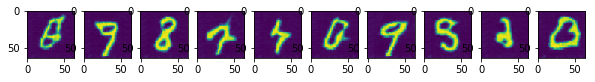

In [68]:
imshow(torchvision.utils.make_grid(output.squeeze().data.cpu(), normalize=True), "", size=(10,10))


# Save

In [ ]:
path = 'Model/'

In [ ]:
torch.save(d.state_dict(), 'Model/d.pth')

In [22]:
torch.save(g.state_dict(), 'Model/g.pth')